# Trading Strategy Optimization

This notebook performs parameter optimization for a trading strategy using historical market data. The optimization process uses Optuna to find the best combination of parameters that maximize the strategy's performance.

In [1]:
import sys
sys.path.append('..')

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import re
from datetime import datetime, time, timedelta

from src.data.data_loader import DataLoader
from src.data.data_processor import DataProcessor
from src.indicators.bollinger_bands import add_bollinger_bands
from src.indicators.rsi import add_rsi
from src.indicators.atr import add_atr
from src.strategy.signal_generator import SignalGenerator
from src.strategy.risk_manager import RiskManager
from src.backtest.backtest_engine import BacktestEngine
from src.backtest.performance import PerformanceMetrics
from src.optimization.strategy_optimizer import StrategyOptimizer
from src.visualization.optimization import plot_optimization_progress, plot_parameter_importance, plot_timeframe_analysis, plot_parameter_space
from src.visualization.comparison import plot_parameter_comparison, plot_equity_curves_comparison
os.makedirs('results', exist_ok=True)
os.makedirs('data_cache', exist_ok=True)
os.makedirs('logs', exist_ok=True)

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 8)

c:\Users\duckh\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Configuration Setup

Load the configuration settings for the optimization process, including timeframes to test and parameter ranges.

In [2]:
from src.optimization.config_loader import ConfigLoader

config_loader = ConfigLoader()
config = config_loader.get_config()

optimization_config = config.get("optimization", {})
timeframes = optimization_config.get("timeframes", ["5min", "15min", "30min", "1h", "4h"])
param_ranges = optimization_config.get("parameter_ranges", {})

print("\nOptimization Configuration:")
print(f"Timeframes to test: {timeframes}")
print("\nParameter ranges:")
for param, range_dict in param_ranges.items():
    print(f"- {param}: {range_dict}")

2025-04-22 21:37:47,758 - config_loader - INFO - Loaded strategy configuration from ../config/strategy_config.json



Optimization Configuration:
Timeframes to test: ['5min', '15min', '30min', '1h', '4h', '1d']

Parameter ranges:
- bb_window: {'min': 10, 'max': 50, 'step': 1}
- bb_std: {'min': 1.0, 'max': 3.0, 'step': 0.1}
- rsi_period: {'min': 5, 'max': 30, 'step': 1}
- rsi_lower: {'min': 20, 'max': 40, 'step': 1}
- rsi_upper: {'min': 60, 'max': 80, 'step': 1}
- atr_period: {'min': 5, 'max': 30, 'step': 1}
- take_profit_mult: {'min': 2.0, 'max': 6.0, 'step': 0.2}
- stop_loss_mult: {'min': 0.5, 'max': 2.0, 'step': 0.1}


## 2. Define Training and Testing Periods

Set the date ranges for the training and validation periods, as well as the number of optimization trials.

In [3]:
train_start_date = '2024-01-01'
train_end_date = '2024-06-01'
test_start_date = '2024-06-01' 
test_end_date = '2025-01-01'

N_TRIALS = 100

print(f"Training period: {train_start_date} to {train_end_date}")
print(f"Validation period: {test_start_date} to {test_end_date}")
print(f"Number of optimization trials: {N_TRIALS}")

Training period: 2024-01-01 to 2024-06-01
Validation period: 2024-06-01 to 2025-01-01
Number of optimization trials: 100


## 3. Load Market Data

Load historical market data for both training and validation periods.

In [4]:
loader = DataLoader(cache_dir="data_cache")

print("Loading training data...")
train_data = loader.get_active_contract_data(train_start_date, train_end_date)
print(f"Loaded {len(train_data)} tick data points for training period")

print("\nLoading validation data...")
test_data = loader.get_active_contract_data(test_start_date, test_end_date)
print(f"Loaded {len(test_data)} tick data points for validation period")

if train_data.empty or test_data.empty:
    raise ValueError("Failed to load market data. Please check database connection and date range.")

Loading training data...
Loaded 344027 tick data points for training period

Loading validation data...
Loaded 515128 tick data points for validation period


## 4. Initialize Strategy Optimizer

Create an instance of the StrategyOptimizer with the loaded data.

In [5]:
optimizer = StrategyOptimizer(
    train_data=train_data,
    test_data=test_data,
    initial_capital=100000,
    n_trials=N_TRIALS,
    timeframes=timeframes,
)

## 5. Run Optimization Process

Execute the optimization process to find the best parameter combination.

In [6]:
print(f"Starting optimization with {N_TRIALS} trials...")
best_params = optimizer.optimize()

print("\nOptimization complete!")
print(f"Best parameters: {best_params}")

[I 2025-04-22 21:38:15,301] A new study created in memory with name: no-name-fbca8785-2c99-4f84-b011-e38eeb8119f1


Starting optimization with 100 trials...


2025-04-22 21:38:24,636 - Trial 0, Timeframe: 1h, BB[35, 1.6], RSI[21, 30, 66], ATR[10], TP/SL[4.2/1.6], Trades: 9, Win Rate: 0.33, Sharpe: -3.17, MDD: 0.02, Score: -1.0000
[I 2025-04-22 21:38:24,639] Trial 0 finished with value: -1.0 and parameters: {'timeframe': '1h', 'bb_window': 35, 'bb_std': 1.6, 'rsi_period': 21, 'rsi_lower': 30, 'rsi_upper': 66, 'atr_period': 10, 'take_profit_mult': 4.2, 'stop_loss_mult': 1.6}. Best is trial 0 with value: -1.0.
2025-04-22 21:38:25,075 - Trial 1, Timeframe: 1h, BB[41, 1.7000000000000002], RSI[6, 27, 65], ATR[7], TP/SL[4.4/1.3], Trades: 5, Win Rate: 0.40, Sharpe: -4.99, MDD: 0.01, Score: -1.0000
[I 2025-04-22 21:38:25,078] Trial 1 finished with value: -1.0 and parameters: {'timeframe': '1h', 'bb_window': 41, 'bb_std': 1.7000000000000002, 'rsi_period': 6, 'rsi_lower': 27, 'rsi_upper': 65, 'atr_period': 7, 'take_profit_mult': 4.4, 'stop_loss_mult': 1.3}. Best is trial 0 with value: -1.0.
2025-04-22 21:38:42,991 - Trial 2, Timeframe: 5min, BB[46, 1.1


Optimization complete!
Best parameters: {'timeframe': '5min', 'bb_window': 23, 'bb_std': 1.1, 'rsi_period': 11, 'rsi_lower': 37, 'rsi_upper': 64, 'atr_period': 19, 'take_profit_mult': 5.6000000000000005, 'stop_loss_mult': 1.2000000000000002}


## 6. Analyze Optimization Results

Load and analyze the results of the optimization process.

In [7]:
from src.optimization.optimization_analyzer import OptimizationAnalyzer
analyzer = OptimizationAnalyzer(log_file="logs/optimization_results.log")
opt_df = analyzer.trials_df
print(f"Found {len(opt_df)} optimization trials")
opt_df.head()

Found 91 optimization trials


,trial,timeframe,bb_window,bb_std,rsi_period,rsi_lower,rsi_upper,atr_period,take_profit_mult,stop_loss_mult,total_trades,win_rate,sharpe,max_drawdown,score
0,0,1h,35,1.6,21,30,66,10,4.2,1.6,9,0.33,-3.17,0.02,-1.0000
1,1,1h,41,1.7,6,27,65,7,4.4,1.3,5,0.40,-4.99,0.01,-1.0000
2,2,5min,46,1.1,6,29,73,30,4.6,1.8,27,0.48,-3.29,0.01,0.4897
3,3,5min,16,1.4,9,34,74,29,3.2,1.1,177,0.35,-1.47,0.14,0.0212
4,5,1h,24,2.9,7,32,76,22,1.8,0.8,1,0.00,-42.47,0.00,-1.0000


## 7. Visualize Optimization Results

Generate plots to visualize the optimization process and results.

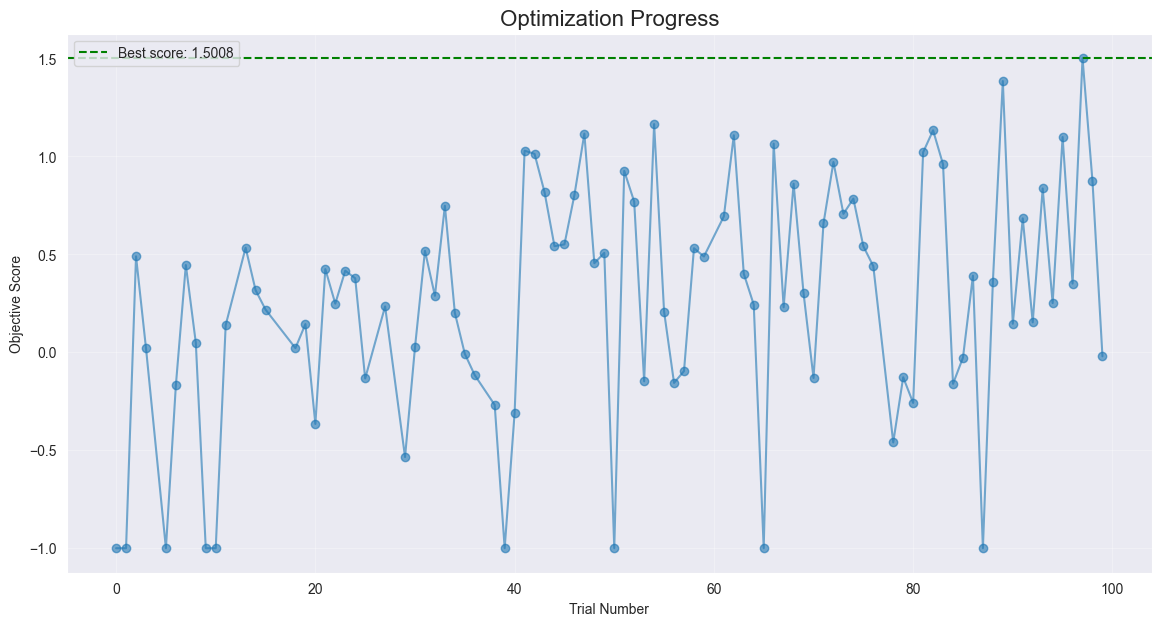

In [8]:
fig_progress = analyzer.plot_optimization_progress(save_path='results/optimization_progress.png')
plt.show()

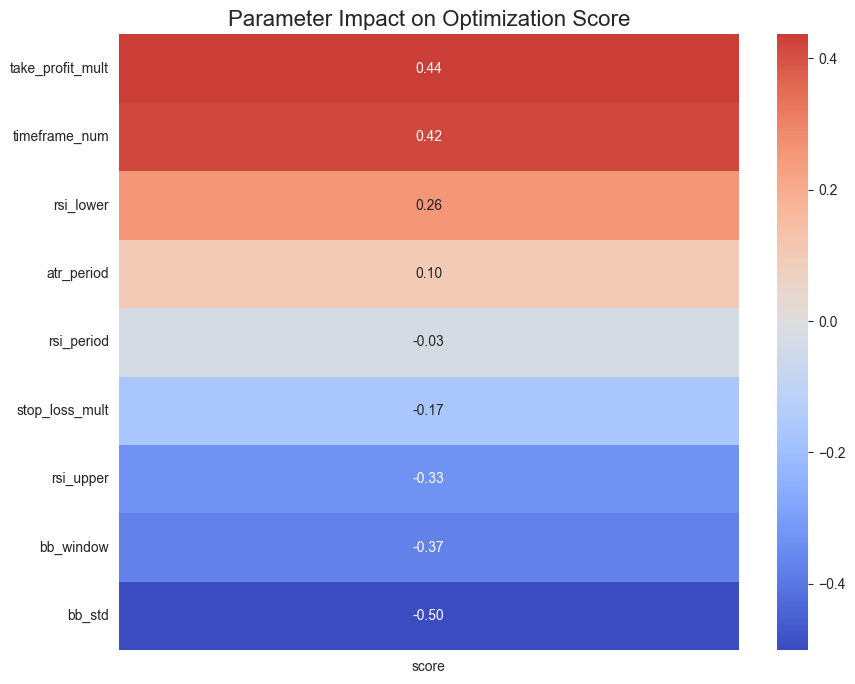

In [9]:
fig_importance = analyzer.plot_parameter_importance(save_path='results/parameter_importance.png')
plt.show()

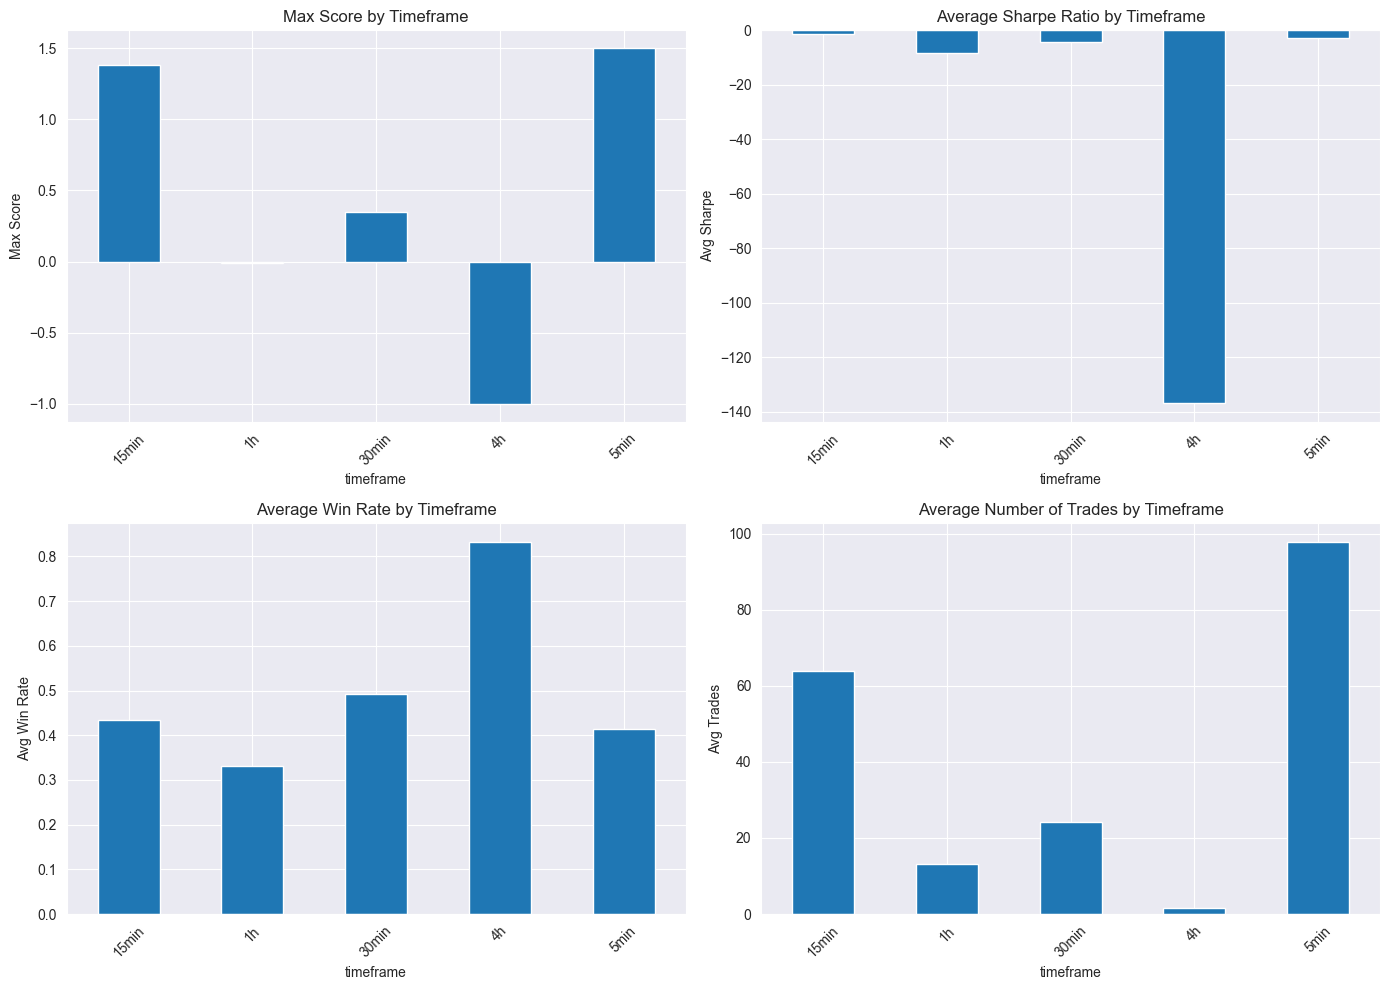

Performance by Timeframe:


total_trades  win_rate      sharpe max_drawdown     score        
                  mean      mean        mean         mean      mean     max
timeframe                                                                  
15min        63.901639  0.433770   -1.264098     0.039836  0.527244  1.3842
1h           13.125000  0.331250   -8.255000     0.020000 -0.567525 -0.0077
30min        24.285714  0.492857   -4.274286     0.030000 -0.117386  0.3505
4h            1.666667  0.833333 -136.763333     0.000000 -1.000000 -1.0000
5min         97.916667  0.413333   -2.854167     0.064167  0.052133  1.5008

In [10]:
fig_timeframe, timeframe_analysis = analyzer.plot_timeframe_analysis(save_dir='results')
plt.show()
print("Performance by Timeframe:")
display(timeframe_analysis)

## 8. Extract Top Parameter Combinations

Identify the best parameter combinations from the optimization trials.

In [11]:
top_params = analyzer.get_top_parameters(n=5)
print("Top 5 parameter combinations:")
display(top_params)
top_params.to_csv('results/top_parameters.csv', index=False)

Top 5 parameter combinations:


,timeframe,bb_window,bb_std,rsi_period,rsi_lower,rsi_upper,atr_period,take_profit_mult,stop_loss_mult,sharpe,total_trades,win_rate,score
88,5min,23,1.1,11,37,64,19,5.6,1.2,-1.16,160,0.40,1.5008
80,15min,15,1.0,10,34,61,17,5.8,0.8,-0.52,90,0.49,1.3842
47,15min,19,1.2,19,32,61,25,5.8,0.9,-0.74,65,0.52,1.1647
73,15min,19,1.1,10,34,62,18,6.0,0.8,-0.69,83,0.48,1.1328
40,15min,12,1.0,19,33,60,23,5.0,1.0,-0.74,71,0.48,1.1160


## 9. Validate Best Parameters

Test the best parameters on the validation dataset and generate performance metrics.

Best parameters from optimization:
- timeframe: 5min
- bb_window: 23
- bb_std: 1.1
- rsi_period: 11
- rsi_lower: 37
- rsi_upper: 64
- atr_period: 19
- take_profit_mult: 5.6000000000000005
- stop_loss_mult: 1.2000000000000002


2025-04-22 21:40:46,138 - 
Out-of-sample validation results:
2025-04-22 21:40:46,138 - Win Rate: 0.3920704845814978
2025-04-22 21:40:46,138 - Profit Factor: 1.1999277238158084
2025-04-22 21:40:46,142 - Sharpe Ratio: -1.321823358615844
2025-04-22 21:40:46,143 - Maximum Drawdown: -0.068982448564242
2025-04-22 21:40:46,145 - Average Trade Return: 67.23542963134824
2025-04-22 21:40:46,145 - Total Return: 0.15262442526316053
2025-04-22 21:40:46,145 - Total Trades: 227
2025-04-22 21:40:46,147 - Average Win: 1029.2386843287989
2025-04-22 21:40:46,149 - Average Loss: -553.1869592677322
2025-04-22 21:40:46,149 - Expectancy: 67.23542963134827



Out-of-Sample Validation Results:
Win Rate: 0.3921
Profit Factor: 1.1999
Sharpe Ratio: -1.3218
Maximum Drawdown: -0.0690
Average Trade Return: 67.2354
Total Return: 0.1526
Total Trades: 227.0000
Average Win: 1029.2387
Average Loss: -553.1870
Expectancy: 67.2354


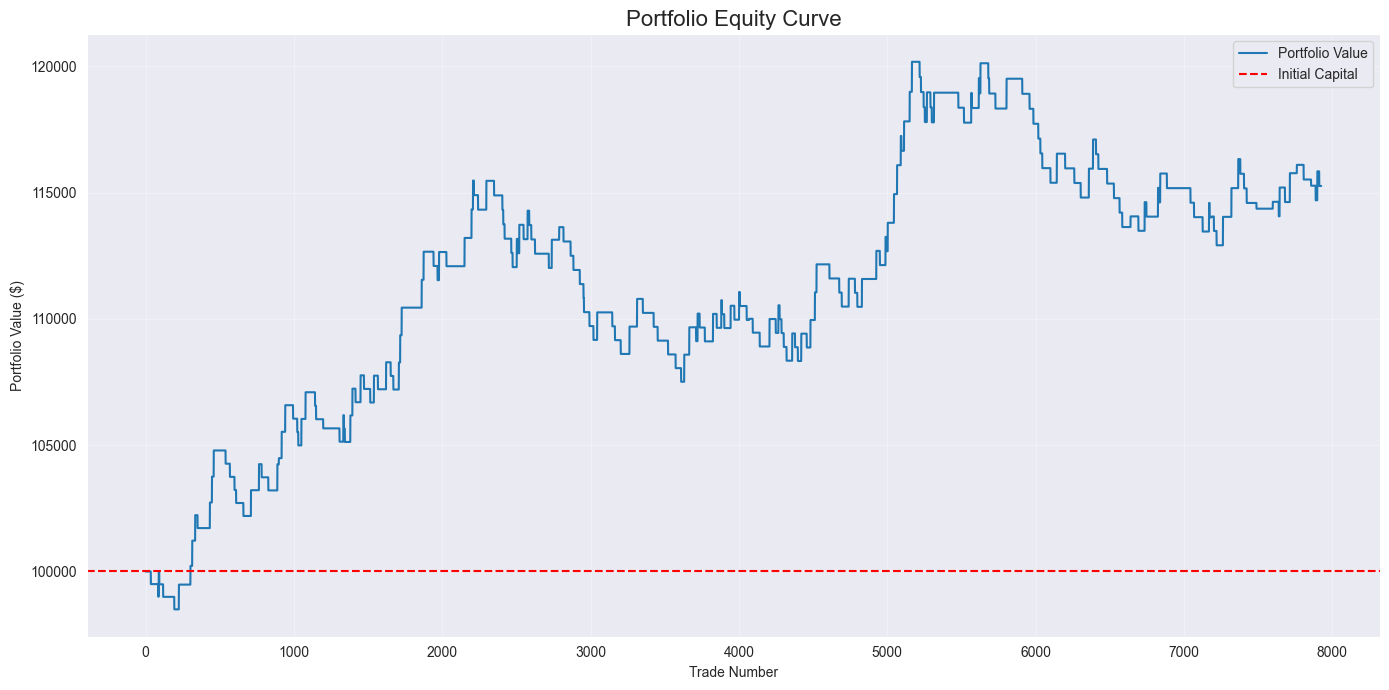

In [12]:
summary = analyzer.generate_summary_report(save_dir='results')
best_params = summary['best_parameters']

print("Best parameters from optimization:")
for param, value in best_params.items():
    print(f"- {param}: {value}")

validation_results, metrics = optimizer.validate_best_parameters(best_params)

print("\nOut-of-Sample Validation Results:")
if metrics is not None:
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}" if isinstance(value, (int, float)) else f"{metric}: {value}")
else:
    print("Validation failed or no trades were executed")

if validation_results and 'portfolio_history' in validation_results and len(validation_results['portfolio_history']) > 1:
    from src.visualization.backtest import plot_equity_curve
    fig = plot_equity_curve(
        validation_results['portfolio_history'],
        initial_capital=100000,
        save_path='results/validation_equity_curve.png'
    )
    plt.show()
else:
    print("No equity curve available - insufficient data")

## 10. Compare Default vs. Optimized Parameters

Compare the performance of the default parameters against the optimized parameters.

2025-04-22 21:40:46,909 - trading_pipeline - INFO - Starting backtest from 2024-06-01 to 2025-01-01 with 15min timeframe
2025-04-22 21:40:46,911 - trading_pipeline - INFO - Loading market data


Running backtest with default parameters...


2025-04-22 21:40:47,619 - trading_pipeline - INFO - Resampling data to 15min timeframe
2025-04-22 21:40:56,500 - trading_pipeline - INFO - Adding indicators to data
2025-04-22 21:40:56,547 - trading_pipeline - INFO - Generating trading signals
2025-04-22 21:40:56,565 - trading_pipeline - INFO - Running backtest simulation
2025-04-22 21:40:57,119 - trading_pipeline - INFO - Calculating performance metrics
2025-04-22 21:40:57,127 - trading_pipeline - INFO - Backtest completed. Summary of results:
2025-04-22 21:40:57,128 - trading_pipeline - INFO - Win Rate: 0.3684210526315789
2025-04-22 21:40:57,129 - trading_pipeline - INFO - Profit Factor: 1.030822291910174
2025-04-22 21:40:57,130 - trading_pipeline - INFO - Sharpe Ratio: -1.735632741277589
2025-04-22 21:40:57,130 - trading_pipeline - INFO - Maximum Drawdown: -0.053319868862606985
2025-04-22 21:40:57,130 - trading_pipeline - INFO - Average Trade Return: 8.887175751877233
2025-04-22 21:40:57,133 - trading_pipeline - INFO - Total Return:

Performance with Default Parameters:
Win Rate: 0.3684
Profit Factor: 1.0308
Sharpe Ratio: -1.7356
Maximum Drawdown: -0.0533
Average Trade Return: 8.8872
Total Return: 0.0068
Total Trades: 76.0000
Average Win: 806.7486
Average Loss: -456.5320
Expectancy: 8.8872


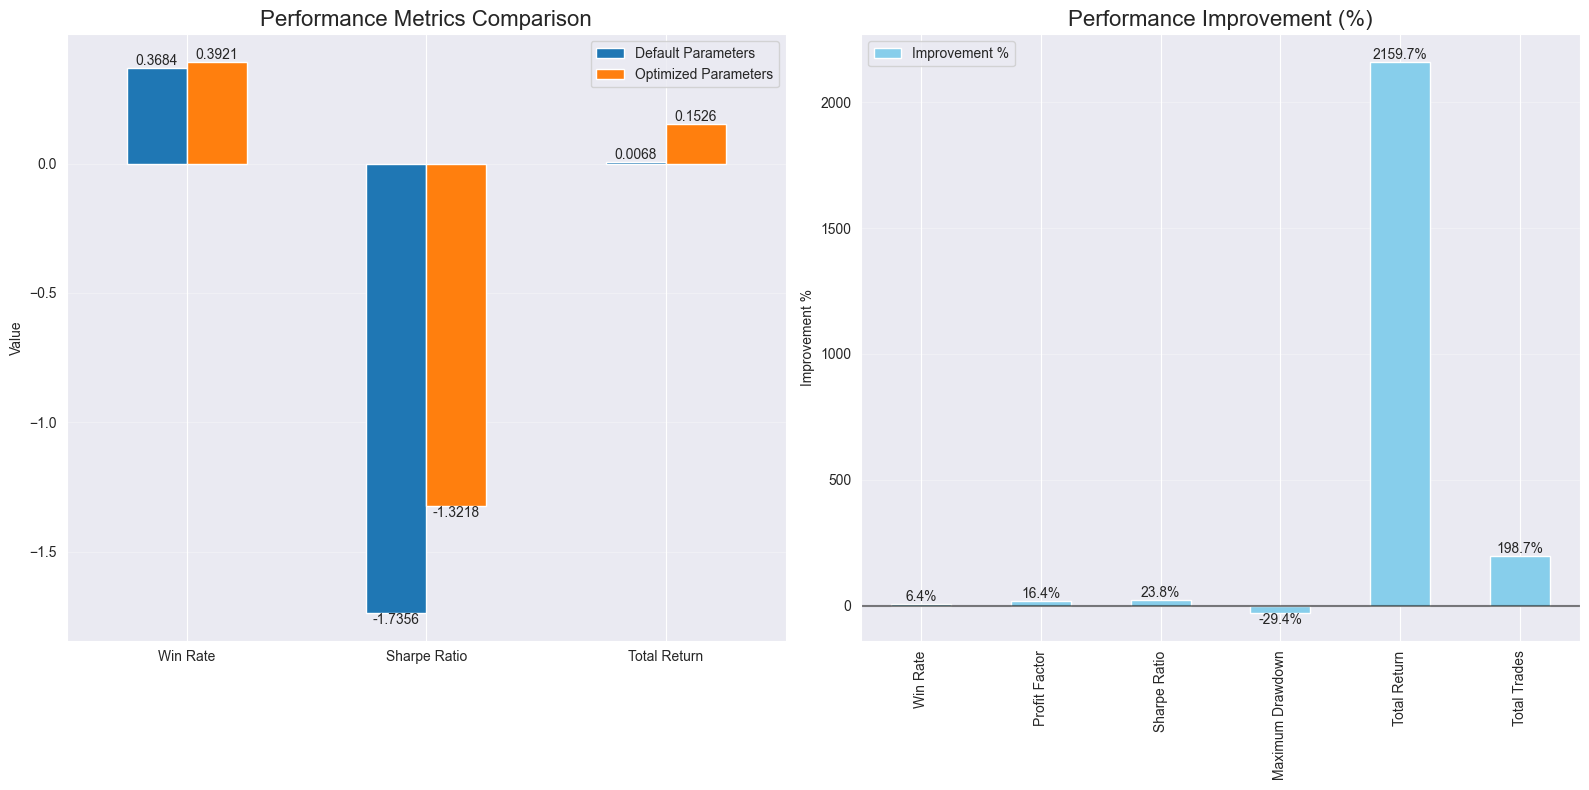

Comparison of Default vs Optimized Parameters:


,Default Parameters,Optimized Parameters,Improvement,Improvement %
Win Rate,0.368421,0.392070,0.023649,6.419132
Profit Factor,1.030822,1.199928,0.169105,16.404906
Sharpe Ratio,-1.735633,-1.321823,0.413809,23.841990
Maximum Drawdown,-0.053320,-0.068982,-0.015663,-29.374753
Total Return,0.006754,0.152624,0.145870,2159.678640
Total Trades,76.000000,227.000000,151.000000,198.684211


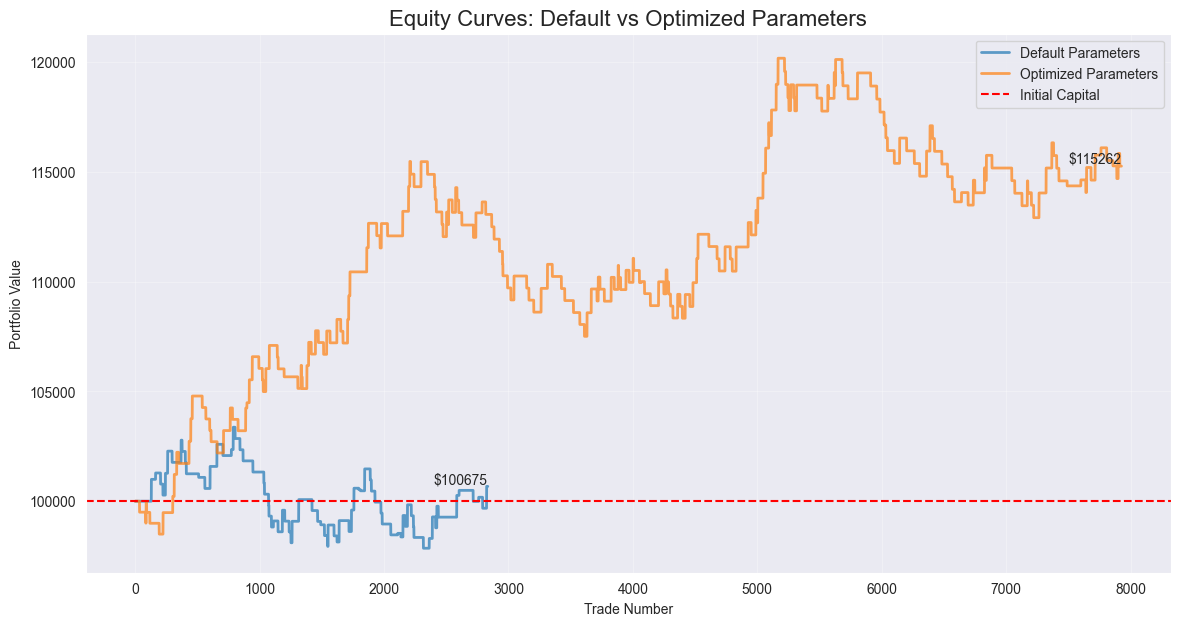

In [13]:
from src.pipeline import TradingPipeline


default_params = config['parameters'].copy()
print("Running backtest with default parameters...")

pipeline_default = TradingPipeline(config)
default_results, default_signals_df = pipeline_default.run_backtest(test_start_date, test_end_date, default_params['default_timeframe'])

if default_results and 'trades' in default_results and not default_results['trades'].empty:
    default_performance = PerformanceMetrics(
        default_results['trades'],
        default_results['portfolio_history']
    )
    default_metrics = default_performance.generate_report()
    
    print("Performance with Default Parameters:")
    for metric, value in default_metrics.items():
        print(f"{metric}: {value:.4f}" if isinstance(value, (int, float)) else f"{metric}: {value}")
else:
    default_metrics = None
    print("No trades were executed with default parameters")

if default_metrics and metrics:
    fig_comparison, comparison_df = plot_parameter_comparison(
        default_metrics, 
        metrics, 
        save_path='results/metrics_comparison.png'
    )
    plt.show()
    
    print("Comparison of Default vs Optimized Parameters:")
    display(comparison_df)
    comparison_df.to_csv('results/parameter_comparison.csv')
    
    fig_curves = plot_equity_curves_comparison(
        default_results['portfolio_history'],
        validation_results['portfolio_history'],
        save_path='results/default_vs_optimized.png'
    )
    plt.show()
else:
    print("Cannot compare metrics - insufficient data")

## 11. Save Optimized Parameters

Save the optimized parameters to configuration files for future use.

In [14]:
best_trial = analyzer.get_top_parameters(n=1).iloc[0].to_dict()

optimized_config = config.copy()

optimized_config['parameters']['bb_window'] = best_params['bb_window']
optimized_config['parameters']['bb_std'] = best_params['bb_std']
optimized_config['parameters']['rsi_period'] = best_params['rsi_period']
optimized_config['parameters']['rsi_lower'] = best_params['rsi_lower']
optimized_config['parameters']['rsi_upper'] = best_params['rsi_upper']
optimized_config['parameters']['atr_period'] = best_params['atr_period']
optimized_config['parameters']['take_profit_mult'] = best_params['take_profit_mult']
optimized_config['parameters']['stop_loss_mult'] = best_params['stop_loss_mult']

if 'timeframe' in best_params:
    optimized_config['parameters']['default_timeframe'] = best_params['timeframe']
else:
    optimized_config['parameters']['default_timeframe'] = best_trial.get('timeframe', config['parameters']['default_timeframe'])

optimized_config['optimization_results'] = {
    'date': datetime.now().strftime('%Y-%m-%d %H:%M'),
    'train_period': f'{train_start_date} to {train_end_date}',
    'test_period': f'{test_start_date} to {test_end_date}',
    'trials': N_TRIALS,
    'best_score': float(best_trial['score']) if 'score' in best_trial else float(best_params.get('score', 0))
}

if metrics:
    optimized_config['performance'] = {
        metric: float(value) if isinstance(value, (int, float, np.number)) else value 
        for metric, value in metrics.items()
        if metric in ['Win Rate', 'Profit Factor', 'Sharpe Ratio', 'Maximum Drawdown', 'Total Return', 'Total Trades']
    }

output_path = '../config/optimized_parameters.json'
with open(output_path, 'w') as f:
    json.dump(optimized_config, f, indent=4)

print(f'Optimized parameters saved to {output_path}')

optimized_params = {
    'parameters': best_params,
    'optimization_info': {
        'date': datetime.now().strftime('%Y-%m-%d %H:%M'),
        'train_period': f'{train_start_date} to {train_end_date}',
        'test_period': f'{test_start_date} to {test_end_date}',
        'best_score': float(best_trial['score']) if 'score' in best_trial else float(best_params.get('score', 0))
    },
    'performance': optimized_config.get('performance', {})
}

with open('results/optimized_parameters.json', 'w') as f:
    json.dump(optimized_params, f, indent=4)
    
print('Optimized parameters also saved to results/optimized_parameters.json')

Optimized parameters saved to ../config/optimized_parameters.json
Optimized parameters also saved to results/optimized_parameters.json
